In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import awkward as aw
import numpy as np
import uproot
import hist
import pandas as pd

import pyvista as pv

: 

In [ ]:
#data_name = "2500000_Distribution_RandomConcreteAir_LXenA"
data_name = 'DistributionThroughRock_Analysis'
#data_name = 'events'

data = uproot.open(f"/data/bkoberg/zData/{data_name}.root:events/events")

df_pri = pd.DataFrame({ "x_pri": data['xp_pri'].array(),
                    "y_pri":data['yp_pri'].array(),
                    "z_pri": data['zp_pri'].array(),
                    "e_pri": data['e_pri'].array(),
                    "vol_pri": data['vol_pri'].array(),
                    "type_pri": aw.flatten(data['type_pri'].array()),})


with uproot.open(f"/data/bkoberg/zData/{data_name}.root") as file:
    tree = file["events/events"]
    for chunk in tree.iterate(step_size=25):  # Beispiel mit 25 Mio Events pro Chunk
        # Verarbeiten Sie jeden Chunk separat
        print(f"Processing chunk with {len(chunk)} events")
        df_chunk = pd.DataFrame({"x": aw.flatten(data['NAct_x'].array()),
                                 "y": aw.flatten(data['NAct_y'].array()),
                                 "z": aw.flatten(data['NAct_z'].array()),
                                 "element": aw.flatten(data['NAct_name'].array()),
                                 "process": aw.flatten(data['NAct_process'].array()),
                                 "volume": aw.flatten(data['NAct_volume'].array()),
        })



Processing chunk with 25 events


In [ ]:
df = pd.DataFrame({
    



# Positions

In [13]:

# Beispiel-Daten (ersetze durch deine Daten)

pos_pri = df_pri[df_pri['type_pri']=='neutron']
pos_pri = pos_pri[['x_pri', 'y_pri', 'z_pri']].sample(frac=0.1, random_state=1)  # Zufällige Auswahl von 10% der Daten



x = pos_pri['x_pri']
y = pos_pri['y_pri']
z = pos_pri['z_pri']

points = np.column_stack((x, y, z))

# PyVista-Plot
cloud = pv.PolyData(points)
plotter = pv.Plotter()
plotter.add_mesh(cloud, color="blue", point_size=1, render_points_as_spheres=True)
plotter.show()

Widget(value='<iframe src="http://localhost:35869/index.html?ui=P_0x7fda6b273af0_0&reconnect=auto" class="pyvi…

In [14]:
# Beispiel-Daten (ersetze durch deine Daten)

print(df['volume'].unique())
pos = df.loc[(df['volume']=='Water') | (df['volume']=='LXeContainer'), ['x','y','z','process']].sample(frac=0.1, random_state=1)  # Zufällige Auswahl von 10% der Daten

x = pos['x']  
y = pos['y'] 
z = pos['z']  

points = np.column_stack((x, y, z))

colors = [
    'red' if process == 'nCapture' else 
    'blue' if process == 'RadioactiveDecay' else 
    'green'  # Standardfarbe für alle anderen Prozesse
    for process in pos['process']
]

colors_rgb = np.array([matplotlib.colors.to_rgb(color) for color in colors])


# PyVista-Plot
cloud = pv.PolyData(points)
cloud["colors"] = colors_rgb 
plotter = pv.Plotter()
plotter.add_mesh(cloud, scalars="colors", rgb=True, point_size=5, render_points_as_spheres=True)
plotter.show()

['RockPhysicalVolume' 'ConcretePhysicalVolume']


ValueError: RGB array must be n_points/n_cells by 3/4 in shape.

NameError: name 'df' is not defined

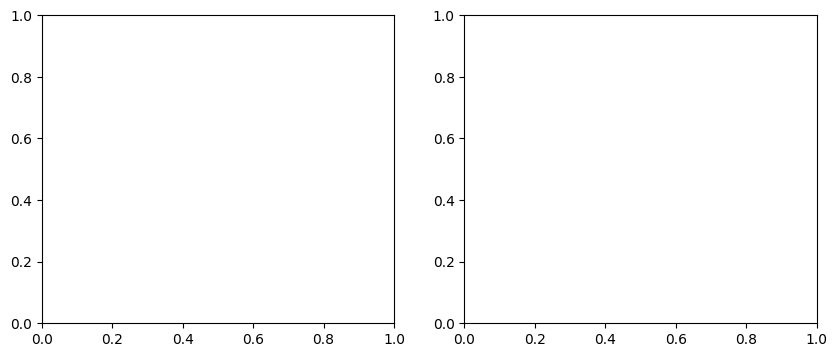

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

bins = 200

im2 = axs[1].hist2d(df['x'], df['y'], bins=bins, cmap='viridis')  # 2D-Histogramm
im1 = axs[0].hist2d(df_pri.loc[df_pri['type_pri']=='neutron','x_pri'], df_pri.loc[df_pri['type_pri']=='neutron','y_pri'], bins=bins, cmap='viridis')  # 2D-Histogramm

# Farbleiste hinzufügen
cbar1 = fig.colorbar(im1[3], ax=axs[0], label='Counts')
cbar2 = fig.colorbar(im2[3], ax=axs[1], label='Counts')

fig.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(10, 4))

im1 = axs[0].hist2d(df_pri.loc[df_pri['type_pri']=='neutron','x_pri'], df_pri.loc[df_pri['type_pri']=='neutron','z_pri'], bins=bins, cmap='viridis')  # 2D-Histogramm
im2 = axs[1].hist2d(df['x'], df['z'], bins=bins, cmap='viridis')  # 2D-Histogramm

# Farbleiste hinzufügen
cbar1 = fig.colorbar(im1[3], ax=axs[0], label='Counts')
cbar2 = fig.colorbar(im2[3], ax=axs[1], label='Counts')

fig.tight_layout()
plt.show()




# Energy

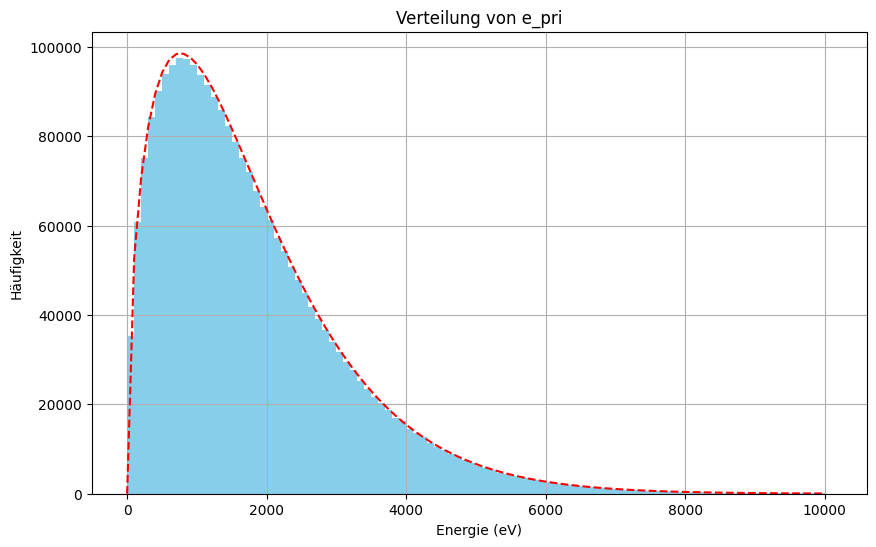

In [ ]:
vergl = np.loadtxt("/home/bkoberg/XeSim/notebooks/ThermicNeutronsDistributions.txt", skiprows=2)

# Bin-Breite festlegen
bin_width = 100  #
bins = np.arange(df_pri['e_pri'].min(), df_pri['e_pri'].max() + bin_width, bin_width)

# Histogramm erstellen
plt.figure(figsize=(10, 6))
plt.grid()
plt.hist(df_pri['e_pri'], bins=bins, color='skyblue')
plt.plot(vergl[:,0]*1000, vergl[:,1]*df_pri.__len__(), color='red', label='Thermic Neutrons', linestyle='--')

# Achsentitel und Diagrammtitel
plt.xlabel('Energie (eV)')
plt.ylabel('Häufigkeit')
plt.title('Verteilung von e_pri')

# Diagramm anzeigen
plt.show()



# Rest

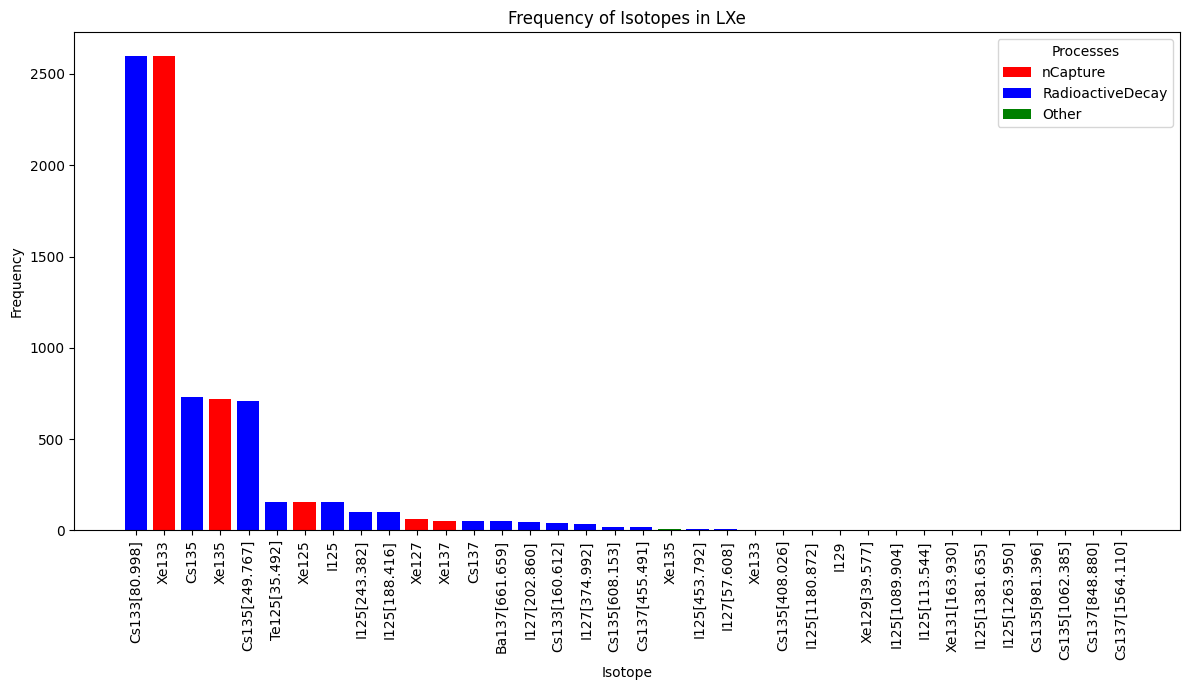

process
nCapture            721
neutronInelastic      9
Name: count, dtype: int64


In [ ]:
elements = df[df['volume'] == 'LXe']
elements = elements[['element','process']]


counted_elements = elements.value_counts()

colors = [
    'red' if process == 'nCapture' else 
    'blue' if process == 'RadioactiveDecay' else 
    'green'  # Standardfarbe für alle anderen Prozesse
    for process in counted_elements.index.get_level_values('process')
]

plotted_elements = [f"{element},  {process}" for element, process in counted_elements.index]


plt.figure(figsize=(12, 7))
plt.bar(plotted_elements, counted_elements.values, color=colors)

plt.xlabel('Isotope')
plt.ylabel('Frequency')
plt.title('Frequency of Isotopes in LXe')

x_positions = np.arange(len(plotted_elements)) + np.linspace(0, 0.1, len(plotted_elements))
plt.xticks(ticks = x_positions,fontsize=10, rotation = 90, labels=counted_elements.index.get_level_values('element'))
legend_elements = [
    matplotlib.patches.Patch(facecolor='red', label='nCapture'),
    matplotlib.patches.Patch(facecolor='blue', label='RadioactiveDecay'),
    matplotlib.patches.Patch(facecolor='green', label='Other')
]
plt.legend(handles=legend_elements, title="Processes")

plt.tight_layout()

plt.savefig(f"/home/bkoberg/XeSim/zData/{data_name}_elements.png")
plt.savefig(f"/home/bkoberg/XeSim/zData/{data_name}_elements.pdf")


plt.show()

print(df.loc[df['element']== 'Xe135','process'].value_counts())


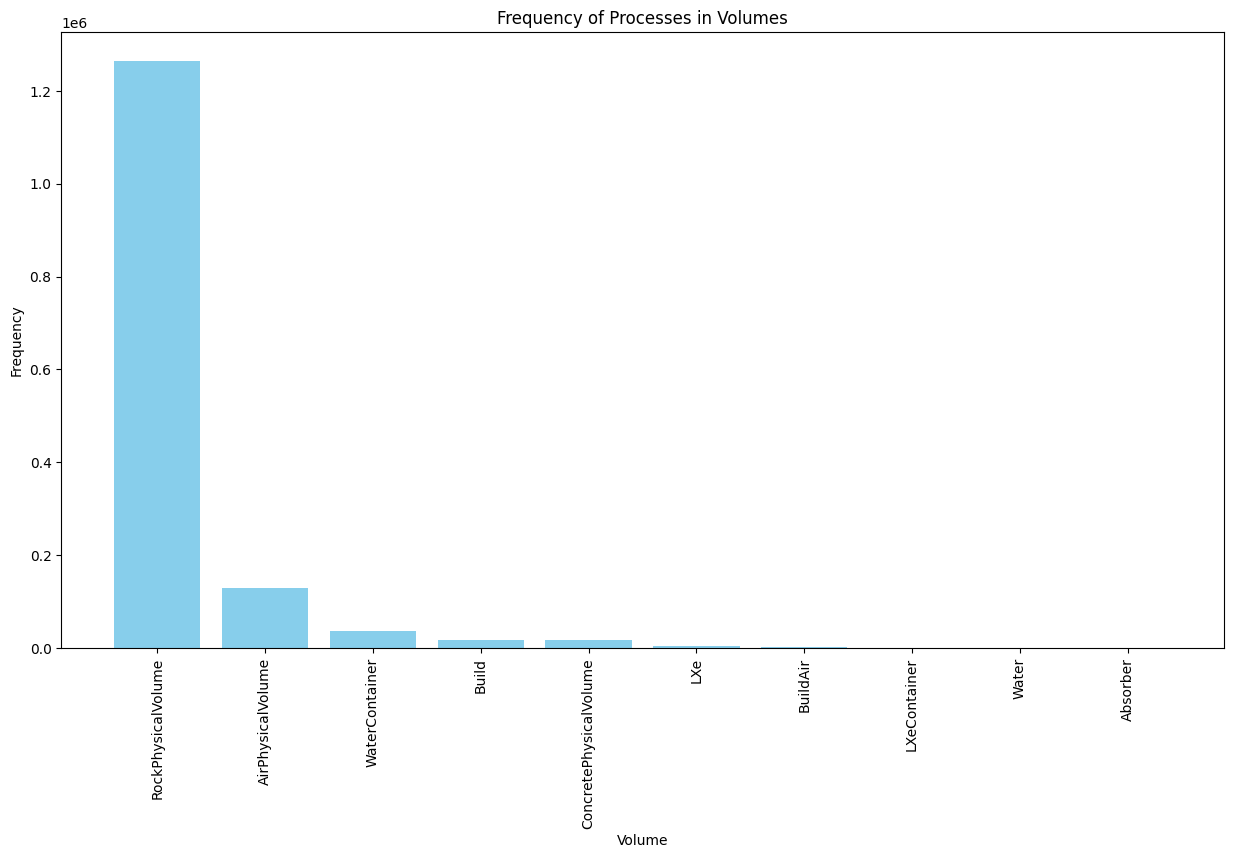

0.33752


In [ ]:
elements = df[['volume','process']]

counted_elements = elements.value_counts()


plotted_volumes = [f"{volume}" for volume, process in counted_elements.index]
frequencies = counted_elements.values # Häufigkeiten


# Erstelle das Histogramm
plt.figure(figsize=(15, 8))
plt.bar(plotted_volumes, frequencies, color='skyblue')

# Achsentitel und Diagrammtitel
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.title('Frequency of Processes in Volumes')
plt.xticks(rotation=90)

# Diagramm anzeigen
plt.savefig(f"/home/bkoberg/XeSim/zData/{data_name}_volumes.png")
plt.savefig(f"/home/bkoberg/XeSim/zData/{data_name}_volumes.pdf")
plt.show()


print(df[df['volume']=='LXe'].__len__() / df_pri.__len__()*100) 